In [99]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy

Data Precipitation preparation

In [100]:
# Total Precipitation preparation
# Load CSV
df_csv = pd.read_csv('/Users/Jia/Downloads/data_skripsi/curah_hujan/tp_arrange.csv')

In [101]:
# Mengonversi kolom 'time' ke tipe data datetime
df_csv['time'] = pd.to_datetime(df_csv['time'])

# Menambahkan kolom 'month'
df_csv['month'] = df_csv['time'].dt.month

# Menambahkan kolom 'year'
df_csv['year'] = df_csv['time'].dt.year

# Melakukan group by bulan, longitude, dan latitude, dan menghitung rata-rata tp
tp_mean_monthly = df_csv.groupby(['month', 'year', 'longitude', 'latitude'], as_index=False)['tp'].mean()

Spatial Join df and gdf

In [102]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [103]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs="EPSG:4326")

<Axes: >

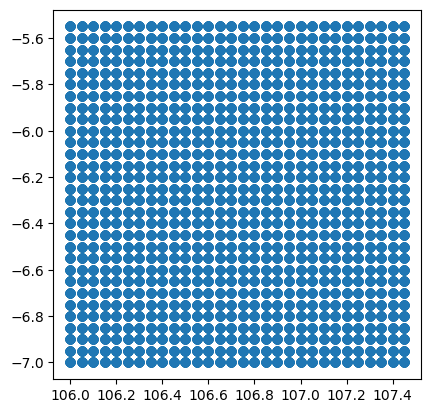

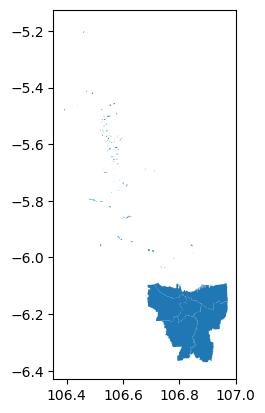

In [104]:
gdf_csv.plot()
gdf_shapefile.plot()

In [105]:
# spatial join
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')
result_pop = result[['longitude', 'latitude', 'tp', 'month', 'year', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1440 entries, 406 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  1440 non-null   float64       
 1   latitude   1440 non-null   float64       
 2   tp         1440 non-null   float64       
 3   month      1440 non-null   int32         
 4   year       1440 non-null   int32         
 5   KABKOT     1440 non-null   object        
 6   geometry   1440 non-null   geometry      
 7   time       1440 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 90.0+ KB


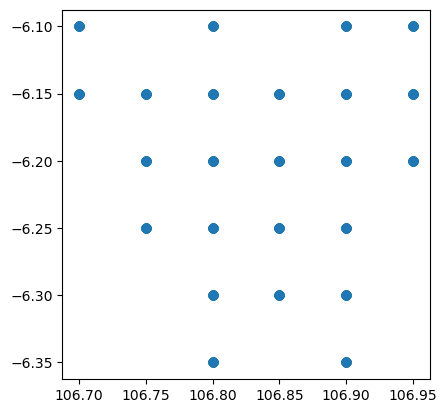

In [106]:
result_pop.plot()
result_pop.info()

In [107]:
result_pop

,longitude,latitude,tp,month,year,KABKOT,geometry,time
406,106.80,-6.35,8.222184,1,2018,JAKARTA SELATAN,POINT (106.80000 -6.35000),2018-01-01
436,106.80,-6.30,7.843826,1,2018,JAKARTA SELATAN,POINT (106.80000 -6.30000),2018-01-01
437,106.85,-6.30,7.883238,1,2018,JAKARTA SELATAN,POINT (106.85000 -6.30000),2018-01-01
465,106.75,-6.25,7.415669,1,2018,JAKARTA SELATAN,POINT (106.75000 -6.25000),2018-01-01
466,106.80,-6.25,7.465468,1,2018,JAKARTA SELATAN,POINT (106.80000 -6.25000),2018-01-01
...,...,...,...,...,...,...,...,...
53628,106.90,-6.15,8.131620,12,2022,JAKARTA UTARA,POINT (106.90000 -6.15000),2022-12-01
53629,106.95,-6.15,8.344428,12,2022,JAKARTA UTARA,POINT (106.95000 -6.15000),2022-12-01
53656,106.80,-6.10,7.512688,12,2022,JAKARTA UTARA,POINT (106.80000 -6.10000),2022-12-01
53658,106.90,-6.10,7.869198,12,2022,JAKARTA UTARA,POINT (106.90000 -6.10000),2022-12-01


Dissolved Result

In [108]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month'], aggfunc='mean')

# Reset indeks untuk membuat kolom 'KABKOT' 'month' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [109]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,geometry,longitude,latitude,tp,year,time
0,JAKARTA BARAT,1,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,9.264916,2020.0,2020-01-01 09:36:00
1,JAKARTA BARAT,2,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,10.695420,2020.0,2020-02-01 09:36:00
2,JAKARTA BARAT,3,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,7.989386,2020.0,2020-02-29 14:24:00
3,JAKARTA BARAT,4,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,6.768114,2020.0,2020-03-31 14:24:00
4,JAKARTA BARAT,5,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,3.957347,2020.0,2020-04-30 14:24:00


In [110]:
dissolved_result_df = pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [111]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=['year', 'KABKOT', 'month'])

In [112]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')
polygon_result.rename(columns= {'KABKOT_left':'KABKOT', 'index_right':'index'}, inplace=True)
polygon_result.drop(columns={'KABKOT_right'}, inplace=True)

In [113]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT', 'geometry', 'index',
       'month', 'longitude', 'latitude', 'tp', 'year', 'time'],
      dtype='object')


Peta Spasial Rata-Rata per Bulan Tahun 2018-2022

In [114]:
import calendar

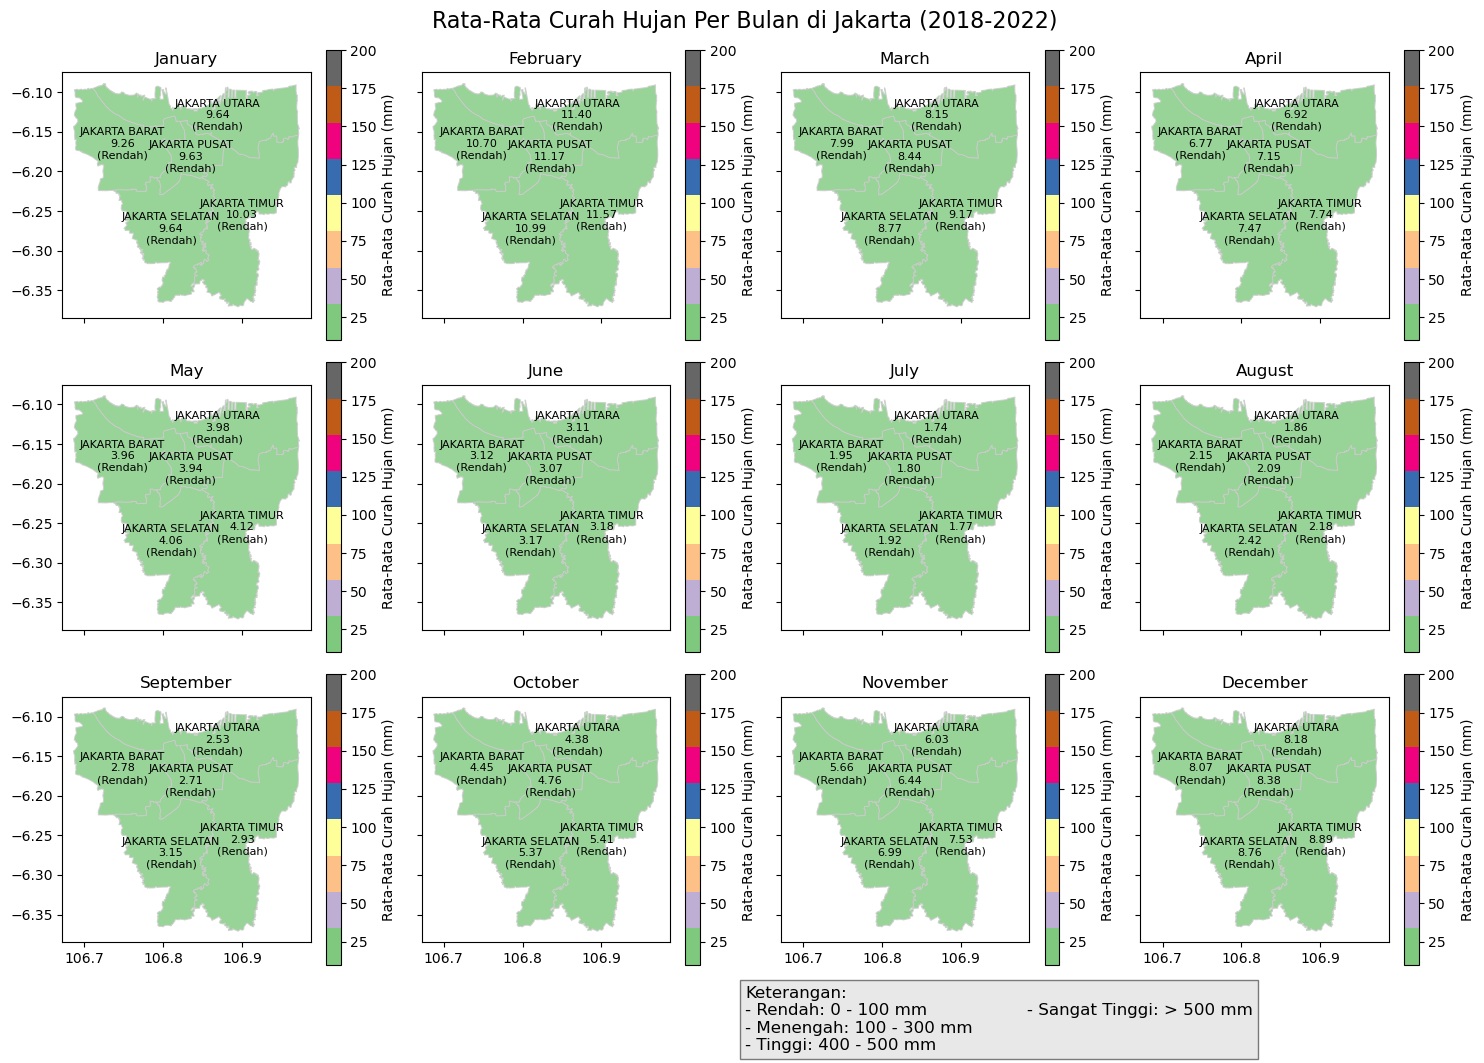

In [115]:
# Function to determine the category based on PM10 value
def kategoriTP(nilai):
    if nilai <= 100:
        return "Rendah"
    elif nilai <= 300:
        return "Menengah"
    elif nilai <= 500:
        return "Tinggi"
    else:
        return "Sangat Tinggi"

# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Rata-Rata Curah Hujan Per Bulan di Jakarta (2018-2022)', fontsize=16)

# Iterate through each month and plot the data
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month
    data_monthly = polygon_result[polygon_result['month'] == month]
                                      
    # Plot the map for the current month with custom color range
    data_monthly.plot(ax=ax, column="tp", legend=True, legend_kwds={"label": "Rata-Rata Curah Hujan (mm)"}, 
                      vmin=10, vmax=200, cmap="Accent", linewidth=0.8, edgecolor="0.8", alpha=0.8)

    # Annotate each polygon with average PM25 value and PSU category
    for idx, row in data_monthly.iterrows():
        nilai_tp = row['tp']
        category = kategoriTP(nilai_tp)
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y,
                f"{row['KABKOT']}\n{nilai_tp:.2f}\n({category})", 
                fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Using the calendar module to get the month name

# Add a description below the entire map
overall_description = f"Keterangan:\n- Rendah: 0 - 100 mm                   - Sangat Tinggi: > 500 mm\n- Menengah: 100 - 300 mm\n- Tinggi: 400 - 500 mm"

# Add a text box below all the subplots
fig.text(0.5, -0.06, overall_description, ha='left', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

Grafik Siklus Bulanan Curah Hujan Tahun 2018-2022

In [116]:
dissolved_result_df['month_name'] = pd.to_datetime(dissolved_result_df['month'], format='%m').dt.month_name()

dissolved_result_df = dissolved_result_df.set_index('month_name')

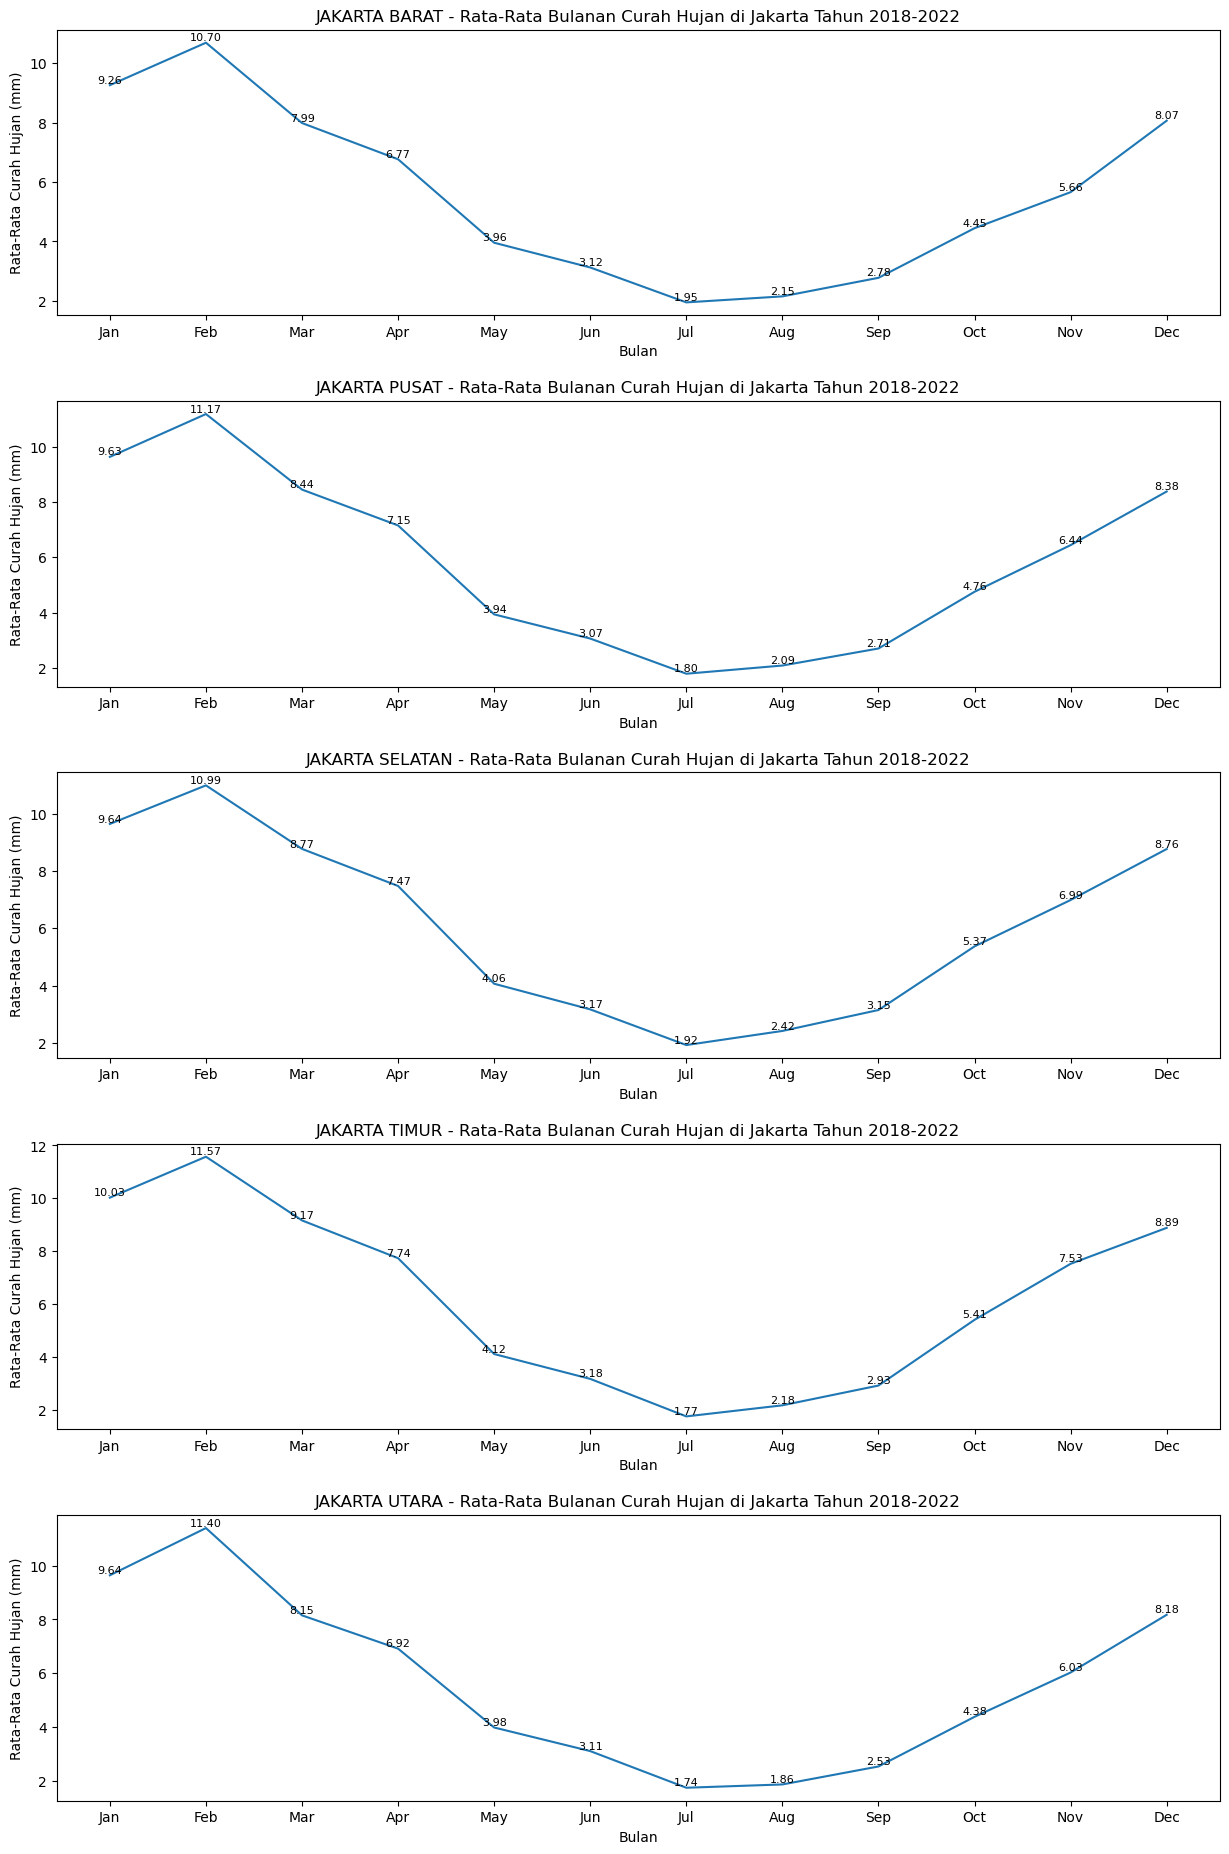

In [117]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 23))
cities = list(dissolved_result_df['KABKOT'].unique())

# Iterate through each city and plot the data
for city, ax in zip(cities, axs):
    # Filter data for the current city
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current city
    ax.plot(data_city['tp'])
    ax.set_title(f'{city} - Rata-Rata Bulanan Curah Hujan di Jakarta Tahun 2018-2022')
    ax.set_xlabel('Bulan')
    ax.set_ylabel('Rata-Rata Curah Hujan (mm)')
    ax.set_xticks(range(0, 12))  # Adjusted to start from 0
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

    # Annotate the average PM2.5 value for each month
    for month in range(1, 13):
        avg_tp_monthly = data_city[data_city['month'] == month]['tp'].mean()
        ax.text(month - 1, avg_tp_monthly, f"{avg_tp_monthly:.2f}",
                ha='center', va='bottom', fontsize=8, color='black')

# Adjust layout to fit the subplots within the figure with added space
plt.subplots_adjust(hspace=0.3)

plt.show()

(-)

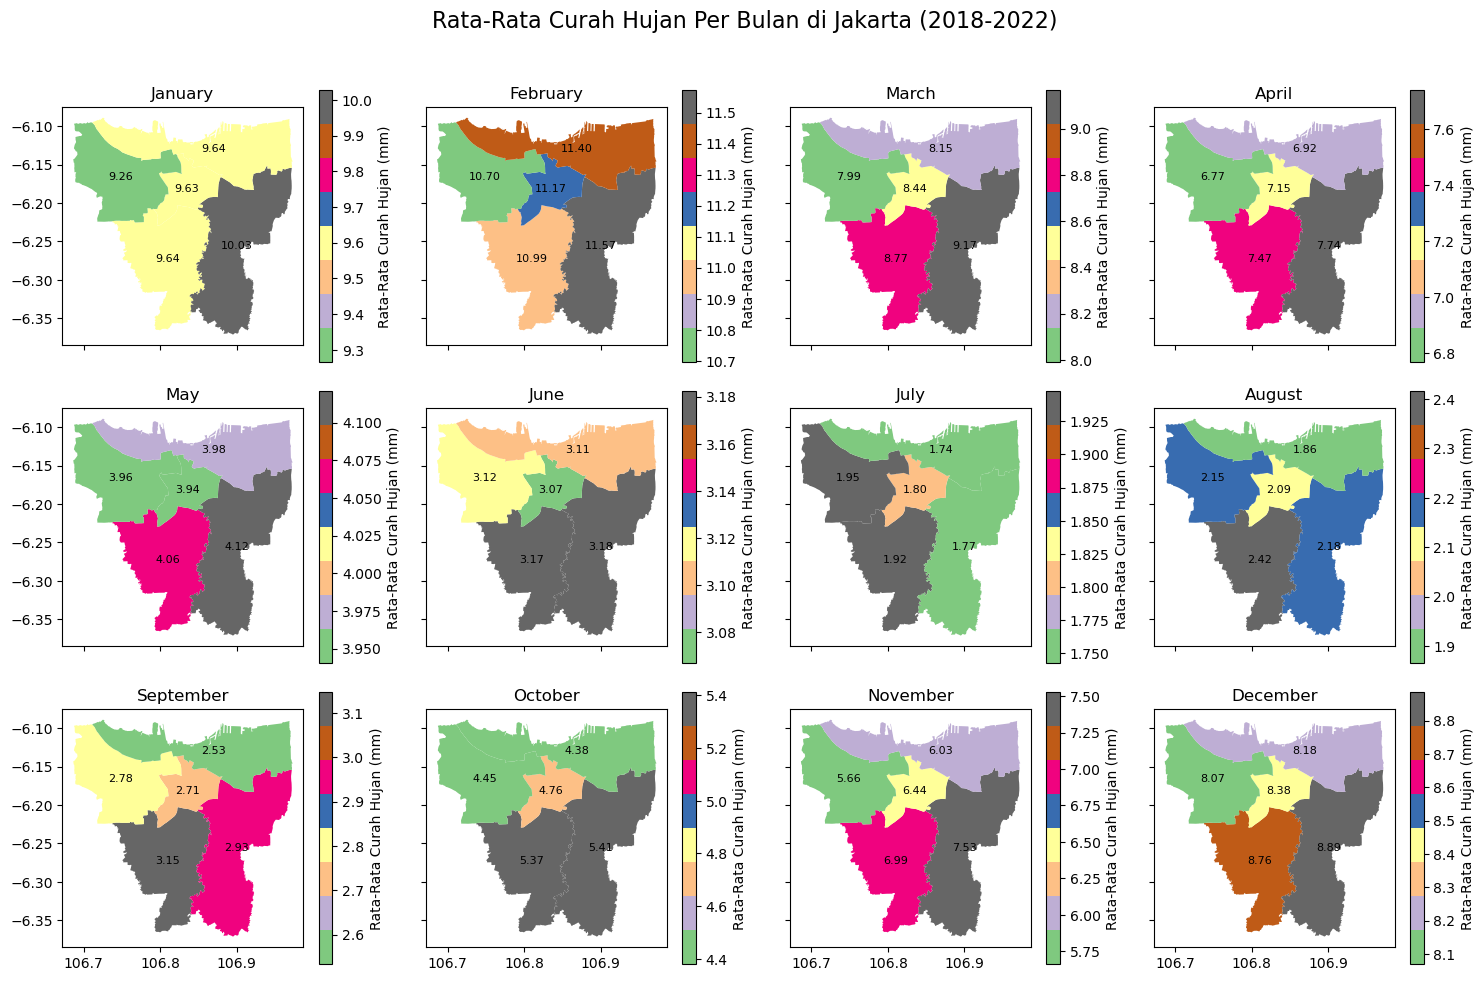

In [118]:
# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Rata-Rata Curah Hujan Per Bulan di Jakarta (2018-2022)', fontsize=16)

# Iterate through each month and plot the data
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month
    data_monthly = polygon_result[polygon_result['month'] == month]

    # Plot the map for the current month
    data_monthly.plot(ax=ax, column="tp", legend=True, legend_kwds={"label": "Rata-Rata Curah Hujan (mm)"})

    # Annotate each polygon with average tp value
    for idx, row in data_monthly.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['tp']:.2f}", fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Menggunakan modul calendar untuk mendapatkan nama bulan

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

cmap = plt.get_cmap('Accent')
plt.set_cmap(cmap)

# Show the plot
plt.show()

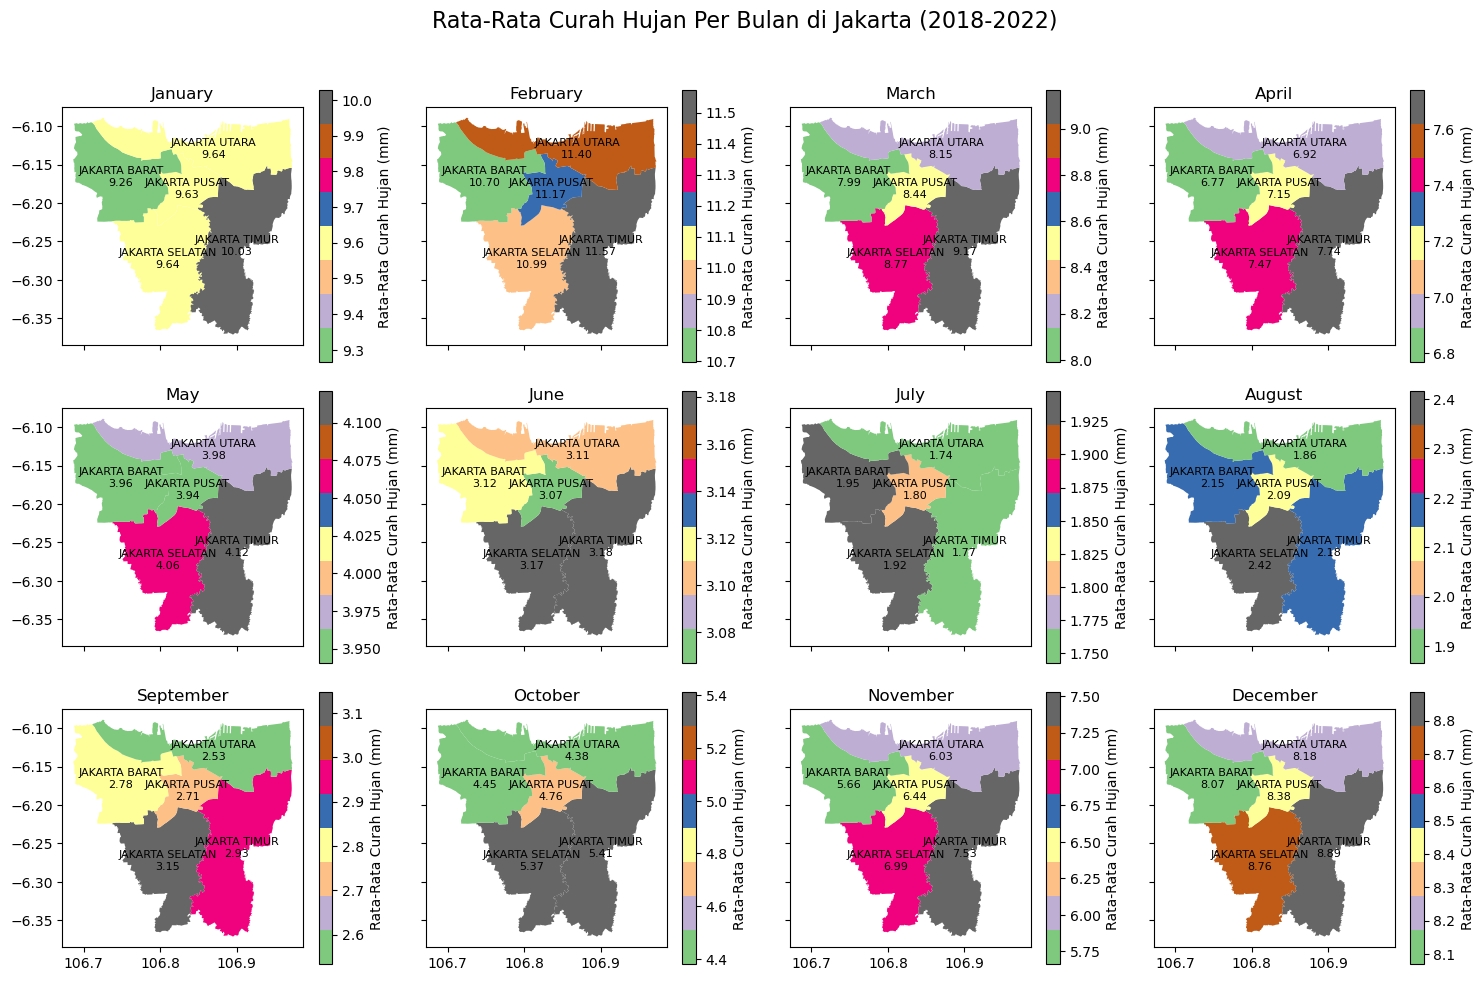

In [119]:
# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Rata-Rata Curah Hujan Per Bulan di Jakarta (2018-2022)', fontsize=16)

# Iterate through each month and plot the data
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month
    data_monthly = polygon_result[polygon_result['month'] == month]

    # Plot the map for the current month
    data_monthly.plot(ax=ax, column="tp", legend=True, legend_kwds={"label": "Rata-Rata Curah Hujan (mm)"})

    # Annotate each polygon with average tp value
    for idx, row in data_monthly.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['KABKOT']}\n{row['tp']:.2f}", fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Menggunakan modul calendar untuk mendapatkan nama bulan

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

cmap = plt.get_cmap('Accent')
plt.set_cmap(cmap)

# Show the plot
plt.show()